# Analysis of the CatFoodDB

I began this as a way to learn how to use ```scrapy```, and it soon became a full data gathering+cleaning+analysis+prediction project.

In this notebook I'll read the raw data gathered by the spider, and:
- Load it into a Pandas dataframe
- Clean and manipulate it until I'm left with a tidy dataset with correct data types and useful information
- Explore the shape of the data and the relationships between variables and target features through numerical analysis and visualization
- Identify the most important predictors
- Train a machine learning model to be able to predict "paw scores" on its own

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

### Loading and cleaning the data

I begin by loading the csv file created by the spider and taking a good look at it

In [3]:
df = pd.read_csv('./catfood/spiders/food_2020-03-11T08-47-45.csv')#.dropna(axis=1)
df.head()

,brand,dma_ash,dma_cals,dma_carbs,dma_fat,dma_fiber,dma_prot,ga_ash,ga_carbs,ga_fat,ga_fiber,ga_moist,ga_prot,ingredients,ingredients_paws,name,nutrition_paws,potential_allergens,quality_ingredients,questionable_ingredients
0,1st choice,10%,313/100g,40%,11%,7%,32%,9.0%,36.0%,10.0%,6.0%,10.0%,29.0%,"Chicken,chicken meal,rice,pea protein,brown ri...",[3],Weight Control,[2],NaN,"chicken,chicken meal","rice,brown rice"
1,bravo,0%,87/100g,11%,31%,6%,53%,0.0%,2.0%,5.5%,1.0%,82.0%,9.5%,"Turkey,turkey broth,vegetable broth,turkey hea...",[4],Feline Cafe Turkey Fricassee,[4],"dried eggs,salmon oil,dried green lipped mussels","turkey,turkey heart,turkey liver",NaN
2,boreal,8%,352/100g,36%,17%,4%,36%,7.5%,32.0%,15.0%,3.5%,10.0%,32.0%,"Chicken Meal,Brown Rice,Oat Meal,Pearled Barle...",[2],Proper Chicken Meal,[2],herring meal,"chicken meal,herring meal",brown rice
3,blue seal,0%,356/100g,50%,12%,4%,33%,0.0%,45.0%,11.0%,4.0%,10.0%,30.0%,"Poultry By-product Meal,Ground Corn,Ground Whe...",[1],Kat Krunchies,[1],"ground corn,corn gluten meal",NaN,"poultry by-product meal,ground corn,ground whe..."
4,best breed,9%,348/100g,22%,19%,8%,42%,8.0%,20.0%,17.0%,7.0%,10.0%,38.0%,"Chicken Meal,Egg Product,Chicken Fat (Preserve...",[4],Grain Free Cat Diet,[3],"egg product,whitefish meal,fish oil","chicken meal,whitefish meal",NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3165 entries, 0 to 3164
Data columns (total 20 columns):
brand                       3165 non-null object
dma_ash                     3165 non-null object
dma_cals                    3165 non-null object
dma_carbs                   3165 non-null object
dma_fat                     3165 non-null object
dma_fiber                   3165 non-null object
dma_prot                    3165 non-null object
ga_ash                      3165 non-null object
ga_carbs                    3165 non-null object
ga_fat                      3165 non-null object
ga_fiber                    3165 non-null object
ga_moist                    3165 non-null object
ga_prot                     3165 non-null object
ingredients                 3165 non-null object
ingredients_paws            3165 non-null object
name                        3165 non-null object
nutrition_paws              3165 non-null object
potential_allergens         2906 non-null object
quality_ing

As everything has been loaded as plain text, I need to manipulate and convert each column so I end up with numerical values that a machine learning model can understand

In [5]:
# Convert all percent values to floats

percent_cols = ['dma_ash',
                'dma_carbs',
                'dma_fat',
                'dma_fiber',
                'dma_prot',
                'ga_ash',
                'ga_carbs',
                'ga_fat',
                'ga_fiber',
                'ga_moist',
                'ga_prot']

for col in percent_cols:
    df[col] = df[col].str.rstrip('%').astype('float')
    

# Convert the calorie column to floats

df['dma_cals'] = df['dma_cals'].map(lambda x:x.split('/')[0].replace(',', '')).astype('float')
    
    
# Convert "paw score" columns to floats

paw_cols = ['ingredients_paws', 'nutrition_paws']

for col in paw_cols:
    df[col] = df[col].str[1].astype('int')
    
# Convert ingredient columns into lists of strings

ingredient_cols = ['ingredients', 'quality_ingredients', 'questionable_ingredients', 'potential_allergens']

for col in ingredient_cols:
    df[col].fillna('')
    df[col] = df[col].str.split(',')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3165 entries, 0 to 3164
Data columns (total 20 columns):
brand                       3165 non-null object
dma_ash                     3165 non-null float64
dma_cals                    3165 non-null float64
dma_carbs                   3165 non-null float64
dma_fat                     3165 non-null float64
dma_fiber                   3165 non-null float64
dma_prot                    3165 non-null float64
ga_ash                      3165 non-null float64
ga_carbs                    3165 non-null float64
ga_fat                      3165 non-null float64
ga_fiber                    3165 non-null float64
ga_moist                    3165 non-null float64
ga_prot                     3165 non-null float64
ingredients                 3165 non-null object
ingredients_paws            3165 non-null int64
name                        3165 non-null object
nutrition_paws              3165 non-null int64
potential_allergens         2906 non-null object
q

All of the numerical columns are now properly formatted and are of type float, great!
I can start exploring and transforming the data.

### General exploration

Let's take a look at all of the columns that I decided to scrape and the reasons why they might be useful.

In [7]:
df.loc[0]

brand                                                              1st choice
dma_ash                                                                    10
dma_cals                                                                  313
dma_carbs                                                                  40
dma_fat                                                                    11
dma_fiber                                                                   7
dma_prot                                                                   32
ga_ash                                                                      9
ga_carbs                                                                   36
ga_fat                                                                     10
ga_fiber                                                                    6
ga_moist                                                                   10
ga_prot                                                         

- brand: name of the manufacturer
- name: name of the specific product
- ga_\*: Guaranteed Analysis nutritional values, the amount of calories, carbs, fats... declared by the manufacturer expressed as percents
- dma_\*: Dry Matter Analysis nutritional values, the same information as Guaranteed Analysis but normalized for moisture content (this is important because cat food comes in dry and wet formats, and we want to be able to rate them indpendently of that)
- ingredients: list of ingredients, ordered by amount
- quality_ingredients: ingredients that are considered beneficial, good signs of a quality product
- questionable_ingredients: ingredients that are considered inferior, fillers, or even negative
- potential_allergens: ingredients that could be dangerous for allergic cats
- nutrition_paws: arbitrary rating based on the nutritional values, one of my target features!
- ingredients_paws: arbitrary rating based on the quality of the ingredients, the other target feature!

At this point, I decide to drop the Guaranteed Analysis columns except for ```ga_moist``` (which I need if I want to differenciate between dry and wet food), since the more appropriate Dry Matter Analysis columns already include all of the relevant nutritional information.

In [8]:
ga_cols_to_drop = ['ga_ash', 'ga_carbs', 'ga_fat', 'ga_fiber', 'ga_prot']
df.drop(ga_cols_to_drop, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3165 entries, 0 to 3164
Data columns (total 15 columns):
brand                       3165 non-null object
dma_ash                     3165 non-null float64
dma_cals                    3165 non-null float64
dma_carbs                   3165 non-null float64
dma_fat                     3165 non-null float64
dma_fiber                   3165 non-null float64
dma_prot                    3165 non-null float64
ga_moist                    3165 non-null float64
ingredients                 3165 non-null object
ingredients_paws            3165 non-null int64
name                        3165 non-null object
nutrition_paws              3165 non-null int64
potential_allergens         2906 non-null object
quality_ingredients         3058 non-null object
questionable_ingredients    2424 non-null object
dtypes: float64(7), int64(2), object(6)
memory usage: 371.0+ KB


Selecting only wet or only dry foods would be a matter of selecting entries where the ```ga_moist``` column has a value greater than, let's say, 50% (dry food's moisture content goes all the way up to 18.0%, and wet food's starts at 63.0%, 50.0% is just a convenient spot)

In [9]:
wf_moist = df[df['ga_moist'] > 50]['ga_moist']
df_moist = df[df['ga_moist'] < 50]['ga_moist']
print("Wet foods: {:4d}         Min and max moist. contents: {:4.1f}-{:4.1f}%".format(wf_moist.count(), wf_moist.min(), wf_moist.max()))
print("Dry foods: {:4d}         Min and max moist. contents: {:4.1f}-{:4.1f}%".format(df_moist.count(), df_moist.min(), df_moist.max()))

Wet foods: 2166         Min and max moist. contents: 63.0-87.5%
Dry foods:  999         Min and max moist. contents:  0.1-18.0%


I start by taking a look at the distribution of paw score using histograms.

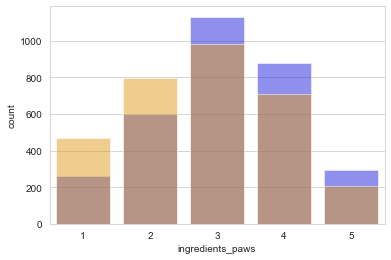

In [10]:
sns.countplot(x=df['nutrition_paws'], color='blue', alpha=0.5, label='Nutrition paws')
sns.countplot(x=df['ingredients_paws'], color='orange', alpha=0.5, label='Ingredients paws')

I can see that, while both score systems result in roughly gaussian distributions, ingredients paws are generally lower. 

Now, I start looking into the relationships between the variable and my target features. One way that I really like and I believe to be appropriate for this problem is studying the correlations using a nice heatmap.

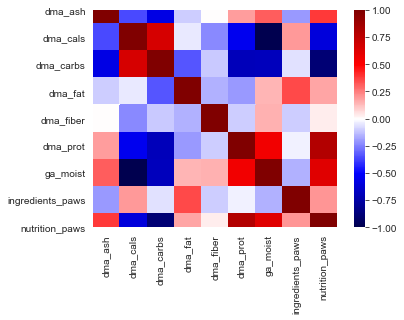

In [11]:
sns.heatmap(df.corr(), cmap='seismic', square=True, vmin=-1, vmax=1)

Focusing on the ```nutrition_paws``` and ```ingredients_paws``` correlations:
- ```nutrition_paws```
    - ```dma_ash```, which refers to the amount of inorganic minerals that remains after a food has been burnt, appears to be slightly positive to the nutrition score
    - ```dma_carbs``` has a highly negative correlation with the nutrition score. This makes sense as carbs are not specially good for cats (they are natural carnivores), and carbs come usually in the way of filler such as rice, grains, starches...
    - ```dma_cals``` has also a negative correlation, it's possible that highly caloric foods are not good either
    - ```dma_prot``` appears to be the most important factor when giving nutrition paws
    - ```ga_moist```, which has a significatively high positive correlation, suggests that wet foods tend to receive better nutrition scores
- ```ingredients_paws```
    - ```dma_fat``` is the only predictor that has sort of a good correlation with the ingredients score
    
Also, ```nutrition_paws``` and ```ingredients_paws``` are surprisingly uncorrelated. I need to find better predictors to estimate the ingredients paws, probaly using the lists of ingredients.

Let's explore that relationship between moisture and nutrition score a bit more.
I start by adding a ```type``` column to store if a food is wet or dry to make my life a bit simpler.

In [12]:
def wet_or_dry(moisture):
    if moisture > 50:
        return 'wet'
    else:
        return 'dry'
    
df['type'] = df['ga_moist'].apply(wet_or_dry)

In [13]:
g_moist = df.groupby('type').mean().sort_values('nutrition_paws', ascending=False)
g_moist

,dma_ash,dma_cals,dma_carbs,dma_fat,dma_fiber,dma_prot,ga_moist,ingredients_paws,nutrition_paws
type,,,,,,,,,
wet,7.730840,82.379040,15.600185,20.444137,6.274238,50.256694,79.915143,2.694829,3.555402
dry,3.244244,368.016016,35.509510,17.434434,5.046046,38.746747,9.772472,3.048048,2.137137


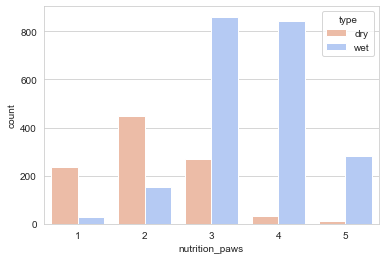

In [14]:
sns.countplot(x=df['nutrition_paws'], hue=df['type'], palette='coolwarm_r')

It appears that not only the mean value of the nutrition score is higher for wet foods, but also there are many more wet foods with high scores than dry foods, and that the latter tend to have generally low scores.

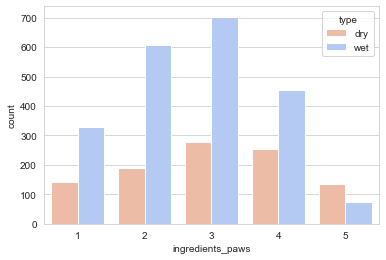

In [15]:
sns.countplot(x=df['ingredients_paws'], hue=df['type'], palette='coolwarm_r')

This moisture content, however, doesn't appear to have any relevant impact in the ingredients score, and both wet and dry distributions look fairly similar.

### Nutrition paws
Let's dive a bit deeper into what decides the nutritional score of a food, and try to build a model to predict it.

As I studied earlier, the variables that correlate the most with ```nutrition_paws``` are the following:

In [16]:
n_paws_preds = ['dma_ash', 'dma_cals', 'dma_carbs', 'dma_prot', 'ga_moist']
n_paws_df = X_n_paws = df[n_paws_preds]
n_paws_df = pd.concat([n_paws_df, df['nutrition_paws']], axis=1)
n_paws_df.head()

,dma_ash,dma_cals,dma_carbs,dma_prot,ga_moist,nutrition_paws
0,10.0,313.0,40.0,32.0,10.0,2
1,0.0,87.0,11.0,53.0,82.0,4
2,8.0,352.0,36.0,36.0,10.0,2
3,0.0,356.0,50.0,33.0,10.0,1
4,9.0,348.0,22.0,42.0,10.0,3


A second correlation heatmap clearly displays this.

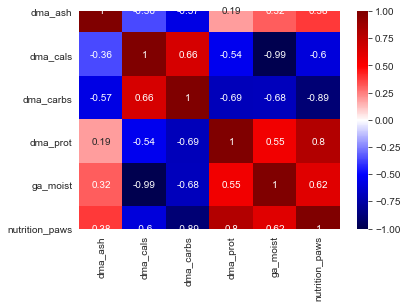

In [17]:
sns.heatmap(n_paws_df.corr(), cmap='seismic', square=True, annot=True, vmin=-1, vmax=1)

Now, I separate the predictors from the target feature, I split them into training and testing sets, and I scale them.

In [18]:
X_n_paws = n_paws_df.drop('nutrition_paws', axis=1)
y_n_paws = n_paws_df['nutrition_paws']
X_train, X_test, y_train, y_test = train_test_split(X_n_paws, y_n_paws, test_size=0.33, random_state=42, stratify=y_n_paws)

In [19]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

I try to predict the nutrition paws using a simple logistic regression model.

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
lr = LogisticRegression(multi_class='multinomial',
                       solver='newton-cg')

In [22]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
y_pred = lr.predict(X_test)

              precision    recall  f1-score   support

           1       0.84      0.70      0.76        87
           2       0.78      0.79      0.78       199
           3       0.81      0.86      0.83       373
           4       0.82      0.83      0.83       289
           5       0.94      0.80      0.87        97

    accuracy                           0.82      1045
   macro avg       0.84      0.80      0.81      1045
weighted avg       0.82      0.82      0.82      1045

[[ 61  26   0   0   0]
 [ 12 157  30   0   0]
 [  0  19 319  35   0]
 [  0   0  43 241   5]
 [  0   0   0  19  78]]


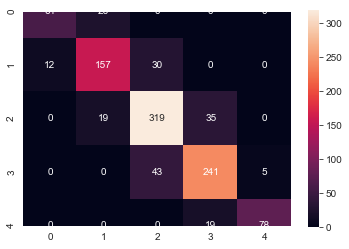

In [24]:
sns.heatmap(data=confusion_matrix(y_test, y_pred),
           square=True,
           annot=True,
           fmt='d')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

That is... actually pretty nice! Both the precision and recall values are above 80 percent, which is not bad given the subjective nature of the ratings. It is also worth noting that when the model does fail, it's not too bad: if a score is off, it's only off by one unit, not any more.

Let's try a more sophisticated model by optimizing a support vector classifier using a grid search.

In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [26]:
param_grid = {'C':[1000, 10000, 100000], 'gamma':[10e-1, 10e-2, 10e-3]}

In [27]:
grid = GridSearchCV(estimator=SVC(), param_grid=param_grid, verbose=10, cv=5)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=1000, gamma=1.0 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... C=1000, gamma=1.0, score=0.803, total=   0.3s
[CV] C=1000, gamma=1.0 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ................... C=1000, gamma=1.0, score=0.812, total=   0.3s
[CV] C=1000, gamma=1.0 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] ................... C=1000, gamma=1.0, score=0.840, total=   0.2s
[CV] C=1000, gamma=1.0 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


[CV] ................... C=1000, gamma=1.0, score=0.860, total=   0.3s
[CV] C=1000, gamma=1.0 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


[CV] ................... C=1000, gamma=1.0, score=0.813, total=   0.4s
[CV] C=1000, gamma=0.1 ...............................................
[CV] ................... C=1000, gamma=0.1, score=0.819, total=   0.2s
[CV] C=1000, gamma=0.1 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.6s remaining:    0.0s


[CV] ................... C=1000, gamma=0.1, score=0.770, total=   0.2s
[CV] C=1000, gamma=0.1 ...............................................
[CV] ................... C=1000, gamma=0.1, score=0.811, total=   0.2s
[CV] C=1000, gamma=0.1 ...............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.9s remaining:    0.0s


[CV] ................... C=1000, gamma=0.1, score=0.834, total=   0.2s
[CV] C=1000, gamma=0.1 ...............................................
[CV] ................... C=1000, gamma=0.1, score=0.806, total=   0.2s
[CV] C=1000, gamma=0.01 ..............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.1s remaining:    0.0s


[CV] .................. C=1000, gamma=0.01, score=0.824, total=   0.1s
[CV] C=1000, gamma=0.01 ..............................................
[CV] .................. C=1000, gamma=0.01, score=0.770, total=   0.1s
[CV] C=1000, gamma=0.01 ..............................................
[CV] .................. C=1000, gamma=0.01, score=0.800, total=   0.1s
[CV] C=1000, gamma=0.01 ..............................................
[CV] .................. C=1000, gamma=0.01, score=0.834, total=   0.1s
[CV] C=1000, gamma=0.01 ..............................................
[CV] .................. C=1000, gamma=0.01, score=0.780, total=   0.1s
[CV] C=10000, gamma=1.0 ..............................................
[CV] .................. C=10000, gamma=1.0, score=0.815, total=   1.3s
[CV] C=10000, gamma=1.0 ..............................................
[CV] .................. C=10000, gamma=1.0, score=0.805, total=   1.2s
[CV] C=10000, gamma=1.0 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1000, 10000, 100000], 'gamma': [1.0, 0.1, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [28]:
grid.best_estimator_

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [29]:
y_pred = grid.predict(X_test)

              precision    recall  f1-score   support

           1       0.82      0.86      0.84        87
           2       0.82      0.80      0.81       199
           3       0.85      0.87      0.86       373
           4       0.84      0.83      0.84       289
           5       0.85      0.82      0.84        97

    accuracy                           0.84      1045
   macro avg       0.84      0.84      0.84      1045
weighted avg       0.84      0.84      0.84      1045

[[ 75  12   0   0   0]
 [ 17 159  23   0   0]
 [  0  21 324  28   0]
 [  0   1  34 240  14]
 [  0   0   0  17  80]]


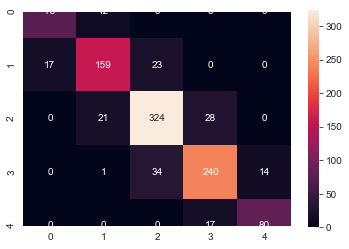

In [30]:
sns.heatmap(data=confusion_matrix(y_test, y_pred),
           square=True,
           annot=True,
           fmt='d')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

The results are a bit better, but still quite similar. The computation and the model are way more complex, but the precision hasn't improved that much. I think I can stick with the logistic regression model. :)

### Ingredients paws
Now it's time to study and try to estimate the ingredients score.
Starting from my initial clean data frame:

In [31]:
df.head()

,brand,dma_ash,dma_cals,dma_carbs,dma_fat,dma_fiber,dma_prot,ga_moist,ingredients,ingredients_paws,name,nutrition_paws,potential_allergens,quality_ingredients,questionable_ingredients,type
0,1st choice,10.0,313.0,40.0,11.0,7.0,32.0,10.0,"[Chicken, chicken meal, rice, pea protein, bro...",3,Weight Control,2,NaN,"[chicken, chicken meal]","[rice, brown rice]",dry
1,bravo,0.0,87.0,11.0,31.0,6.0,53.0,82.0,"[Turkey, turkey broth, vegetable broth, turkey...",4,Feline Cafe Turkey Fricassee,4,"[dried eggs, salmon oil, dried green lipped mu...","[turkey, turkey heart, turkey liver]",NaN,wet
2,boreal,8.0,352.0,36.0,17.0,4.0,36.0,10.0,"[Chicken Meal, Brown Rice, Oat Meal, Pearled B...",2,Proper Chicken Meal,2,[herring meal],"[chicken meal, herring meal]",[brown rice],dry
3,blue seal,0.0,356.0,50.0,12.0,4.0,33.0,10.0,"[Poultry By-product Meal, Ground Corn, Ground ...",1,Kat Krunchies,1,"[ground corn, corn gluten meal]",NaN,"[poultry by-product meal, ground corn, ground ...",dry
4,best breed,9.0,348.0,22.0,19.0,8.0,42.0,10.0,"[Chicken Meal, Egg Product, Chicken Fat (Prese...",4,Grain Free Cat Diet,3,"[egg product, whitefish meal, fish oil]","[chicken meal, whitefish meal]",NaN,dry


I create a smaller dataframe selecting only the ```dma_fat```column, which was the only numerical one that had any impact on the ingredients rating, as well as the text ingredient columns. I concatenate it with ```ingredients_paws```.

In [32]:
i_paws_preds = ['ingredients', 'quality_ingredients', 'questionable_ingredients', 'potential_allergens', 'dma_fat']
i_paws_df = df[i_paws_preds]
i_paws_df = pd.concat([i_paws_df, df['ingredients_paws']], axis=1)
i_paws_df.head()

,ingredients,quality_ingredients,questionable_ingredients,potential_allergens,dma_fat,ingredients_paws
0,"[Chicken, chicken meal, rice, pea protein, bro...","[chicken, chicken meal]","[rice, brown rice]",NaN,11.0,3
1,"[Turkey, turkey broth, vegetable broth, turkey...","[turkey, turkey heart, turkey liver]",NaN,"[dried eggs, salmon oil, dried green lipped mu...",31.0,4
2,"[Chicken Meal, Brown Rice, Oat Meal, Pearled B...","[chicken meal, herring meal]",[brown rice],[herring meal],17.0,2
3,"[Poultry By-product Meal, Ground Corn, Ground ...",NaN,"[poultry by-product meal, ground corn, ground ...","[ground corn, corn gluten meal]",12.0,1
4,"[Chicken Meal, Egg Product, Chicken Fat (Prese...","[chicken meal, whitefish meal]",NaN,"[egg product, whitefish meal, fish oil]",19.0,4


Seein that I only have one lousy numerical predictor, I have to think of a way to use the information contained in the ingredient lists. Since I'm not a cat nutritionist and I don't how good or how bad are the quality and questionable ingredients, I decide to just count the number of ingredients in each category that each food has, and then check if the number correlates to the ingredients score. I also count the total number of ingredients, to see if foods with shorter ingredient lists score better or worse.

In [33]:
i_paws_df['quality_count'] = i_paws_df['quality_ingredients'].str.len().fillna(0)
i_paws_df['questionable_count'] = i_paws_df['questionable_ingredients'].str.len().fillna(0)
i_paws_df['allergen_count'] = i_paws_df['potential_allergens'].str.len().fillna(0)
i_paws_df['ingredient_count'] = i_paws_df['ingredients'].str.len()
i_paws_df.head()

,ingredients,quality_ingredients,questionable_ingredients,potential_allergens,dma_fat,ingredients_paws,quality_count,questionable_count,allergen_count,ingredient_count
0,"[Chicken, chicken meal, rice, pea protein, bro...","[chicken, chicken meal]","[rice, brown rice]",NaN,11.0,3,2.0,2.0,0.0,54
1,"[Turkey, turkey broth, vegetable broth, turkey...","[turkey, turkey heart, turkey liver]",NaN,"[dried eggs, salmon oil, dried green lipped mu...",31.0,4,3.0,0.0,3.0,36
2,"[Chicken Meal, Brown Rice, Oat Meal, Pearled B...","[chicken meal, herring meal]",[brown rice],[herring meal],17.0,2,2.0,1.0,1.0,33
3,"[Poultry By-product Meal, Ground Corn, Ground ...",NaN,"[poultry by-product meal, ground corn, ground ...","[ground corn, corn gluten meal]",12.0,1,0.0,4.0,2.0,32
4,"[Chicken Meal, Egg Product, Chicken Fat (Prese...","[chicken meal, whitefish meal]",NaN,"[egg product, whitefish meal, fish oil]",19.0,4,2.0,0.0,3.0,47


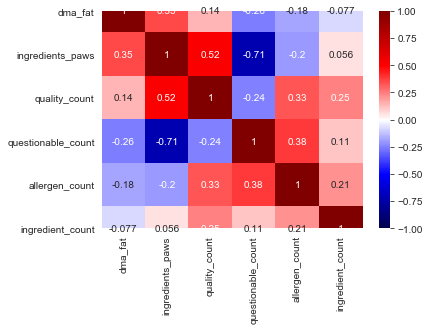

In [34]:
sns.heatmap(i_paws_df.corr(), cmap='seismic', square=True, annot=True, vmin=-1, vmax=1)

Well... It looks like it wasn't a bad idea!
```quality_count```and ```questionable_count``` correlate positively and negatively with ```ingredients_paws``` as expected. The allergens and the fat content don't have as much as an impact, but they're still interesting. On the other hand, it appears that the total amount of ingredients is not an important predictor and bears little to no effect on the ingredients score.

As before, I prepare the data to be fed into a logistic regression model by separing it into predictors and feature, splitting it into training and test batches, and running it through a scaler.

In [35]:
X_i_paws = i_paws_df.drop(['ingredient_count', 'ingredients_paws'], axis=1)
y_i_paws = i_paws_df['ingredients_paws']
X_train, X_test, y_train, y_test = train_test_split(X_n_paws, y_n_paws, test_size=0.33, random_state=42, stratify=y_i_paws)

In [36]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
lr = LogisticRegression(multi_class='multinomial',
                       solver='newton-cg')

In [38]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
y_pred = lr.predict(X_test)

              precision    recall  f1-score   support

           1       0.79      0.70      0.74        89
           2       0.76      0.78      0.77       222
           3       0.81      0.78      0.79       357
           4       0.75      0.84      0.79       267
           5       0.90      0.78      0.83       110

    accuracy                           0.79      1045
   macro avg       0.80      0.78      0.79      1045
weighted avg       0.79      0.79      0.79      1045

[[ 62  27   0   0   0]
 [ 16 174  32   0   0]
 [  0  28 279  50   0]
 [  0   0  34 223  10]
 [  0   0   0  24  86]]


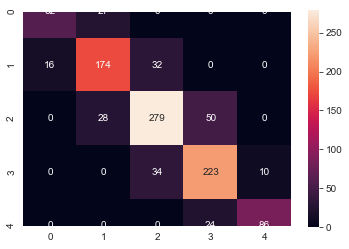

In [40]:
sns.heatmap(data=confusion_matrix(y_test, y_pred),
           square=True,
           annot=True,
           fmt='d')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

The performance is quite similar to that obtained for the estimation of the nutrition paws: nothing too impressive, but in my opinion good enough for the problem at hand! :)